# Function calling using ollama
In this notebook we will do _function calling_ using a locally executed model, [mistral:v0.3](https://ollama.com/library/mistral). This notebook was tested using [ollama 0.1.39](https://ollama.com/) on Windows. Before you can run this notebook, you need to download the model using this terminal command:

```
ollama run mistral:v0.3
```

See also:
* [Mistral Docs: Function calling](https://docs.mistral.ai/capabilities/function_calling)


These helper functions are stored in [function_calling.py](function_calling.py) and not shown for the readers convenience.

In [1]:
from function_calling import function_list_to_json, call_function_from_response, prompt_ollama, act

## Defining function tools
The following two functions will serve as functions the model can call. We also define some image memory, we can manage using the functions.

In [2]:
image_memory = {}

In [3]:
tools = []

@tools.append
def load_image(filename:str, name:str):
    """
    Loads an image from disk and stores it under a specified name
    """
    from skimage.io import imread
    image = imread(filename)
    # store the image in memory
    image_memory[name] = image
    
@tools.append
def show_image(name:str):
    """
    Shows an image specified by a name
    """
    from stackview import imshow
    imshow(image_memory[name])
    

## Function calling using prompts
With this list of tools and a prompt that allows deciding which function to call, a large language model is capable of making the decision which function to call. With some additional infrastructure, as in the `act()` function, we can call functions directly like this:

In [4]:
act("Load the image data/membrane2d.tif and store it as membrane", tools)

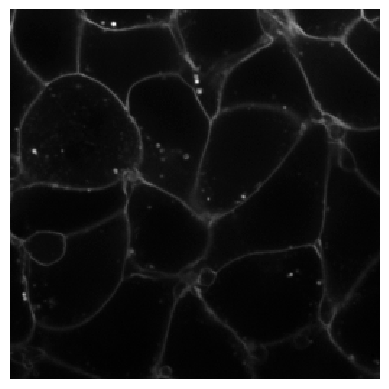

In [5]:
act("Show the membrane image", tools)

## How does it work?
Under the hood, the `act()` function does the following: First, we turn the list of functions into a dictionary, so that we can easily get the function back, after the language model has decided for a function and told us its name.

In [6]:
named_tools = {f.__name__: f for f in tools}
named_tools

{'load_image': <function __main__.load_image(filename: str, name: str)>,
 'show_image': <function __main__.show_image(name: str)>}

We furthermore turn the two functions above into JSON-formatted string. This can be done using python packages like [inspect](https://docs.python.org/3/library/inspect.html) and by accessing the docsting of the function. The `description` specified below will later allow the language model to decide which function fits best to the prompt from the user.

In [7]:
json_text = function_list_to_json(tools)
print(json_text)

[
    {
        "type": "function",
        "function": {
            "name": "load_image",
            "description": "Loads an image from disk and stores it under a specified name",
            "parameters": {
                "type": "object",
                "properties": {
                    "filename": {
                        "type": "<class 'str'>"
                    },
                    "name": {
                        "type": "<class 'str'>"
                    }
                },
                "required": [
                    "filename",
                    "name"
                ]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "show_image",
            "description": "Shows an image specified by a name",
            "parameters": {
                "type": "object",
                "properties": {
                    "name": {
                        "type": "<class 'str'>"
                    }
           

## Prompting
As we have turned the list of functions into a string, we can submit this string together with a task string to the language model. When usinng mistral:v0.3 it must be in the format shown below.

Its answer will be a JSON as well.

In [8]:
task = 'Load the image "data/blobs.tif" and store it as "blobs"'

my_prompt = f"""
[AVAILABLE_TOOLS]{json_text}[/AVAILABLE_TOOLS][INST] {task} [/INST]
"""

answer = prompt_ollama(my_prompt, verbose=True)

message:  [AVAILABLE_TOOLS][ { "type": "function", "function": { "name": "load_image", "description": "Loads an image from disk and stores it under a specified name", "parameters": { "type": "object", "properties": { "filename": { "type": "<class 'str'>" }, "name": { "type": "<class 'str'>" } }, "required": [ "filename", "name" ] } } }, { "type": "function", "function": { "name": "show_image", "description": "Shows an image specified by a name", "parameters": { "type": "object", "properties": { "name": { "type": "<class 'str'>" } }, "required": [ "name" ] } } } ][/AVAILABLE_TOOLS][INST] Load the image "data/blobs.tif" and store it as "blobs" [/INST] 
answer {'model': 'mistral:v0.3', 'created_at': '2024-05-29T09:15:12.7424632Z', 'response': '[TOOL_CALLS] [ { "name": "load_image", "arguments": { "filename": "data/blobs.tif", "name": "blobs" } } ]\n\nNow the image is loaded and stored under the name "blobs"\n\nTo display this image use the show_image function:\n\n[TOOL_CALLS] [ { "name": 

Before executing the function proposed by the language model, we take a look at the images stored in memory:

In [9]:
image_memory.keys()

dict_keys(['membrane'])

Now we call the function.

In [10]:
call_function_from_response(answer["response"], named_tools, verbose=True)

calling load_image with {'filename': 'data/blobs.tif', 'name': 'blobs'}


Afterwards, we show the list of stored images again.

In [11]:
image_memory.keys()

dict_keys(['membrane', 'blobs'])

## Exercise
Write a function that can segment an image and call it using a prompt. 
Ask the language model to segment one of the images above and show the result.